# Разработка стратегии для фитнес сети «Культурист-датасаентист»

Для разработки стратегии удержания клиентов необходимо проанализировать отток клиентов.

Необходимо провести анализ анкет клиентов фитнес-сети и подготовить план по удержанию клиентов.

- 1) выделить целевые группы клиентов;
- 2) предложить меры по снижению оттока;
- 3) определить другие особенности взаимодействия с клиентами.


За индикатор оттока клиента принимаем отсутвие посещений зала в течение месяца.

**План работы:**
- Подготовить данные к анализу;
- Разделить данные на обучающую и валидационную выборку;
- Обучить модели;
- Оценить модель и выбрать наиболее удачную по показателям метрик моделей;
- Кластеризировать пользователей, для этого вначале стандартизировать данные, затем построить матрицу расстояний и построить дендрограмму, обучить модель кластеризации;
- Опредленить кластеры клиентов, склонные к оттоку;
- На основе определения склонности кластеров к оттоку сделать рекомендации для улучшения стратегии удержания клиентов.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Шаг.-Загрузка-данных." data-toc-modified-id="Шаг.-Загрузка-данных.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Шаг. Загрузка данных.</a></span></li><li><span><a href="#Шаг.-Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Шаг.-Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Шаг. Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#шаг.-модель-прогнозирования-оттока-клиентов." data-toc-modified-id="шаг.-модель-прогнозирования-оттока-клиентов.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>шаг. модель прогнозирования оттока клиентов.</a></span></li><li><span><a href="#шаг.-Кластеризация-клиентов." data-toc-modified-id="шаг.-Кластеризация-клиентов.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>шаг. Кластеризация клиентов.</a></span></li><li><span><a href="#Шаг.-Общий-вывод." data-toc-modified-id="Шаг.-Общий-вывод.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Шаг. Общий вывод.</a></span></li></ul></div>

**загрузим необходимые библиотеки**

In [1]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Шаг. Загрузка данных.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

У некоторых колонок есть названия с большой буквы, приведем их к нижнему регистру в соответвие с правилами хорошего кода.

Отсутствующих значенией нет.

In [4]:
df.duplicated().sum()

0

Явных дубликатов в датасете нет.

In [5]:
df.columns = df.columns.str.lower()
df.head(3).T

,0,1,2
gender,1.000000,0.000000,0.000000
near_location,1.000000,1.000000,1.000000
partner,1.000000,0.000000,1.000000
promo_friends,1.000000,0.000000,0.000000
phone,0.000000,1.000000,1.000000
contract_period,6.000000,12.000000,1.000000
group_visits,1.000000,1.000000,0.000000
age,29.000000,31.000000,28.000000
avg_additional_charges_total,14.227470,113.202938,129.448479
month_to_end_contract,5.000000,12.000000,1.000000


В таблице хранятся следующие данные:

- 'gender' — пол;
- 'near_location' — проживание или работа в районе, где находится фитнес-центр;
- 'partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'phone' — наличие контактного телефона;
- 'age' — возраст;
- 'lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:


- 'contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'group_visits' — факт посещения групповых занятий;
- 'avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'churn' — факт оттока в текущем месяце.

**Вывод** Загрузили данные из датасета. Определили значение колонок, привели названия колонок в нижний регистр, убедились в отсутвии пропусков данных.

In [1]:
!pip install pandas-profiling[notebook]
from pandas_profiling import ProfileReport

     |████████████████████████████████| 262 kB 2.2 MB/s            
     |████████████████████████████████| 102 kB 10.3 MB/s           
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 709 kB 15.7 MB/s            
     |████████████████████████████████| 4.7 MB 21.4 MB/s            
     |████████████████████████████████| 2.0 MB 54.2 MB/s            
     |████████████████████████████████| 812 kB 54.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 6.9 MB 53.4 MB/s            
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=12518272af3886ab7f7512b8b7db3ed6f98220a83c5fec62a413dbcfef63cad3
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=9681519bdd0fea98ad75c84ba00b2e45325efed79a4d662884184da8fd6a3362
  Stored 

In [7]:
profile = ProfileReport(df[:5], title="Pandas Profiling Report")

In [8]:
profile.to_widgets()
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# код ревьюера
# !pip install pandas-profiling[notebook]
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df[:5], title="Pandas Profiling Report") # взяла 5 строк, чтобы не перегружать ноутбук


# раскомментить что-нибудь из этого (лучше правда сохранить в html и смотреть отдельно)

# profile.to_widgets()
# profile.to_notebook_iframe()

In [10]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

## Шаг. Исследовательский анализ данных (EDA)

In [11]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


*Описание категориальных данных*

В среднем фитнес клуб посещает поровну мужчин и женщин, большая часть посетителей из близлижащих локаций, чуть меньше половины являются сотрудниками компаний-партнеров клуба, только треть пришла в рамках акции "приведи друга", 90% пользователей оставили свой номер телефона и около 26% имеют подтвержденный факт оттока в текущем месяце.

*Описание количественных данных*

- Длительность текущего действующего абонемента - судя по тому что средняя и медиана сильно различаются (4,68 и 1) и по тому что стандартное отклонение величины относительно большое (4,55) можно предположить что данные распределены ненормально, большая часть клиентов имеет короткие договора на 1 месяц, и меньше 25% клиентов имеют договор на 6 и больше месяцев.

- Возраст клиентов - средняя и медиана этого значения практически равны (29,2 и 29,0), стандартное отклонение относительно небольшое (3,25) говорят о том что средний возраст клиентов 29 лет и данные распределены нормально.

- Суммарная выручка от других услуг фитнес-центра - средняя и медиана близки (146,9 и 136,2), хотя стандарное отклонение достаточно большое (96), можно сказать что данные распределены нормально и составляют в среднем 140 у.е. (тут хотелось бы уточнить величину выручки, потому что для рублей какая-то небольшая сумма).

- Срок до окончания текущего действующего абонемента (в месяцах) - ввиду того что длительность текущего договора распределена ненормально, та же тенденция сохраняется и для срока до окончания абонемента у большинства клиентов это 1 месяц, у 25% больше 6 месяцев, а в среднем 4 месяца.

- Время с момента первого обращения в фитнес-центр (в месяцах). Данные распределены нормально в среднем это 3 месяца, стандарное отклонение 3, максимальный срок посещения фитнес центра составил 31 месяц.

- Средняя частота посещений в неделю за все время с начала действия абонемента - данные распределены нормально в среднем это 1,8 раз в неделю, максимальная частота посещений 6 раз в неделю.

- Средняя частота посещений в неделю за предыдущий месяц - данные согласуются со средним посещением за весь срок действия абонемента в среднем это 1,8 раз в неделю, максимальная частота посещений 6 раз в неделю.



In [12]:
difference = df.groupby('churn').mean().T
difference

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


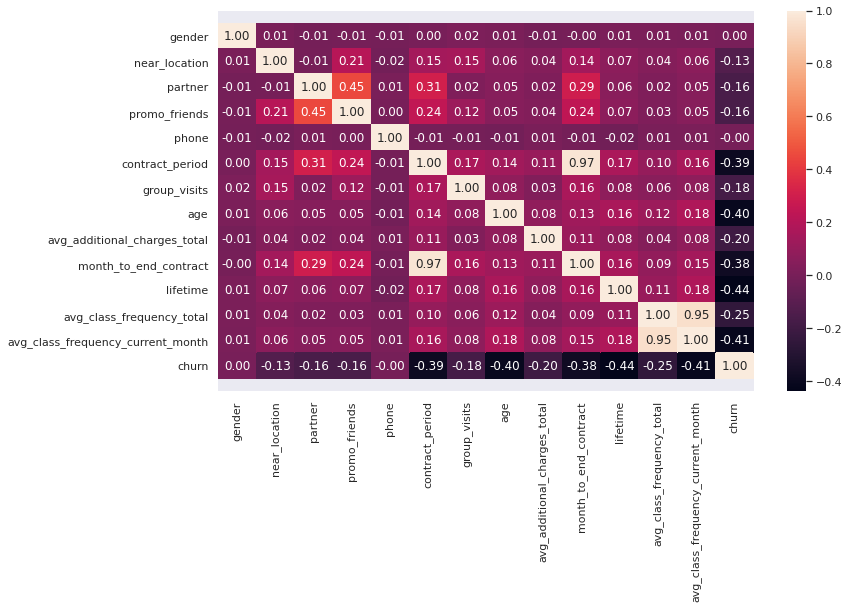

In [13]:
corr = df.corr()
f, ax = plt.subplots(figsize = (12,7))
ax = sns.heatmap(corr, xticklabels = corr.columns, fmt='.2f', 
                 yticklabels = corr.columns, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Сильно коррелирующими оказались данные о сроке абонемента и оставшемся времени до окончания абонемента, и о среднем количестве посещений в последнем месяце и в целом,  что достаточно логично.

In [14]:
df = df.drop('avg_class_frequency_current_month', axis = 1)

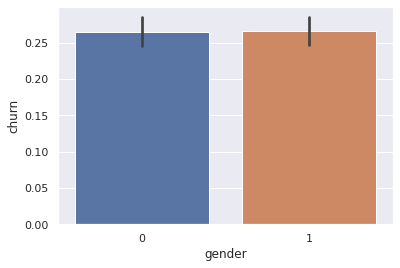

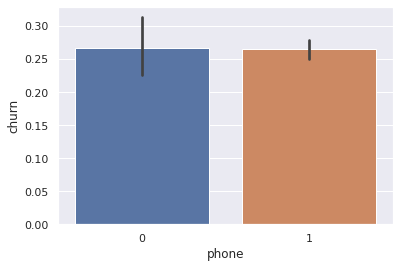

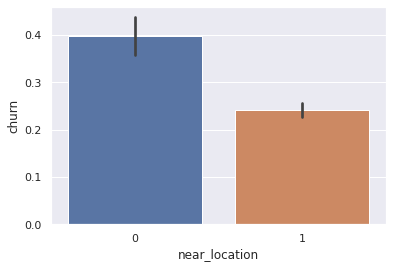

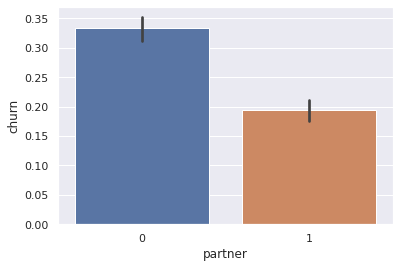

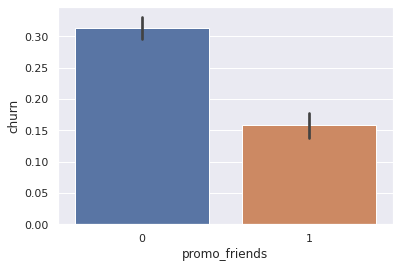

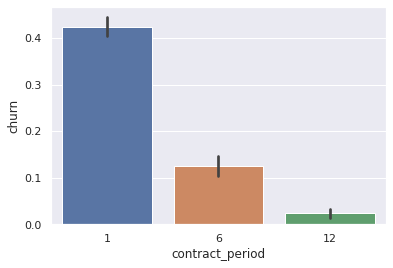

In [15]:
sns.barplot(df['gender'], df['churn'])
plt.show();sns.barplot(df['phone'], df['churn'])
plt.show();
sns.barplot(df['near_location'], df['churn'])
plt.show();
sns.barplot(df['partner'], df['churn'])
plt.show();
sns.barplot(df['promo_friends'], df['churn'])
plt.show();
sns.barplot(df['contract_period'], df['churn'])
plt.show();


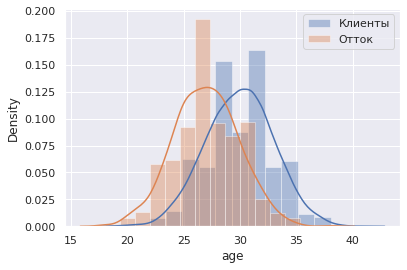

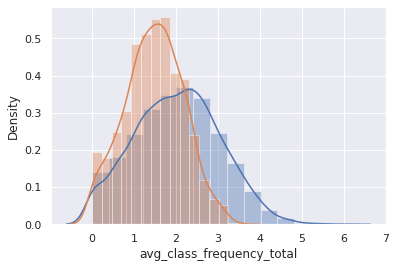

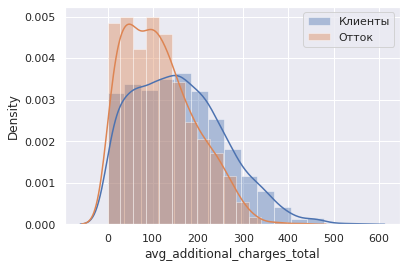

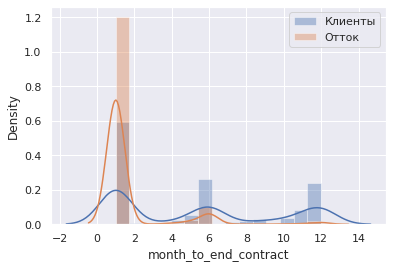

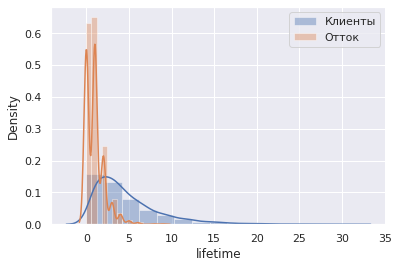

In [16]:
sns.distplot(df.query('churn==0')['age'], bins=15, label ='Клиенты')
sns.distplot(df.query('churn==1')['age'], bins=15, label ='Отток')
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()

sns.distplot(df.query('churn==0')['avg_class_frequency_total'], bins=15, label ='Клиенты')
sns.distplot(df.query('churn==1')['avg_class_frequency_total'], bins=15, label ='Отток')
plt.show()


sns.distplot(df.query('churn==0')['avg_additional_charges_total'], bins=15, label ='Клиенты')
sns.distplot(df.query('churn==1')['avg_additional_charges_total'], bins=15, label ='Отток')
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()

sns.distplot(df.query('churn==0')['month_to_end_contract'], bins=15, label ='Клиенты')
sns.distplot(df.query('churn==1')['month_to_end_contract'], bins=15, label ='Отток')
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()

sns.distplot(df.query('churn==0')['lifetime'], bins=15, label ='Клиенты')
sns.distplot(df.query('churn==1')['lifetime'], bins=15, label ='Отток')
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()


Среди отбывших клиентов нет разницы по половому признаку, оставленного или нет номера телефона, 

Клиенты которые живут по-соседству реже прекращали свои абонементы.
Партнерские и промо программы тоже на первый взгляд тоже работают, так как клиенты партнеры реже прекращают занятия.
Клиенты с абонементом на 1 месяц часто не продлевают свои абонементы, а клиенты купившие абонемент на 12 месяцев отличаются постоянноством. Чем меньше срок оставшегося абонемента, тем больше вероятность прекращения занятий, с другой стороны чем больше вермени прошло с момента приобретения абонемента, тем меньше частота прекращения занятий, вероятно у клиентов формируется привычка к занятиям.
Клиенты посетители групповых программ реже бросали занятия спортом.
Чем старше клиенты тем реже они бросали занятия.


**Вывод по первоначальному анализу данных** 
Пропусков и дубликатов не обнаружили.

Наиболее информативными для дальнейшего анализа выглядат длительность текущих абонементов (в среднем ниже у ушедших), посещение групповых занятий (оставшиеся более склонны к посещению групповых занятий), является ли человек сотрудником компании-партнёра клуба (для таких посетителей действует скидка, что может положительно влиять на решение человека продолжить посещение клуба).

Тогда как на первый взгляд возраст, пол, наличие контактного телефона не отличаются у ушедших и оставшихся клиентов, а значит, возможно не так важны для дальнейшего анализа.

## шаг. модель прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

Разобъем данные на обучающую и валидационную выборку функцией train_test_split().

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

напишем функцию для выведения метрик

In [18]:
# функция для выведения метрик
def print_all_metrics(y_test, y_pred, title):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_test, y_pred)))

Обучим модель на train-выборке двумя способами:
- логистической регрессией

In [19]:
# модель логистической регрессии

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print_all_metrics(y_test, y_pred_lr, title = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.876
	Precision: 0.778
	Recall: 0.760


- случайным лесом

In [20]:
# модель случайного леса

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print_all_metrics(y_test, y_pred_rf, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.892
	Precision: 0.826
	Recall: 0.765


**Вывод:** Построили модель прогнозирования оттока клиентов. Модель логистической регрессии показала себя немного лучше, чем модель градиентного леса по всем метрикам. Выбираем модель логической регрессии.

## шаг. Кластеризация клиентов.

Проведем кластеризацию объектов (клиентов):

- Стандартизируем данные

In [21]:
# стандартизируем данные
sc = StandardScaler()
x_sc_4 = sc.fit_transform(df.drop(columns = ['churn']))

Построем матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

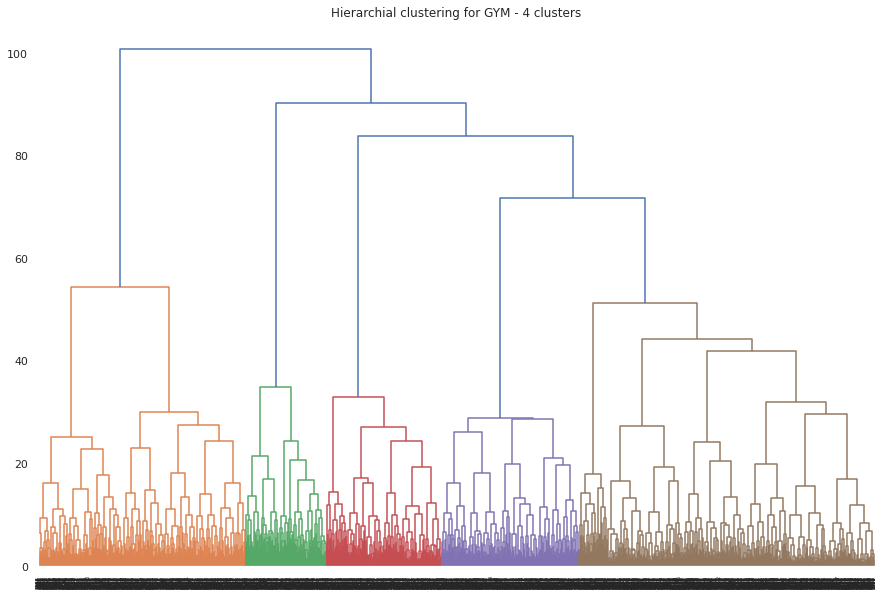

In [22]:
linked = linkage(x_sc_4, method = 'ward')
# график кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM - 4 clusters')
plt.show()

На основании полученных данных можно сделать выводы о 4-5 возможных кластерах.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 

В задании мы договорились за число кластеров принять n=5, чтобы  результаты можно было сравнивать с результатами остальных студентов.
Но на основание дентрограммы можно было взять и 4 кластера.

In [23]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 1)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc_4)

Посмотрим на средние значения признаков для кластеров.

In [24]:
df['cluster'] = labels
# средние значения по кластерам
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.506829,0.503831,0.523316,0.500564,0.516171
near_location,0.998483,0.000000,0.862694,0.951522,1.000000
partner,0.773900,0.467433,0.471503,0.736189,0.231565
promo_friends,1.000000,0.080460,0.305699,0.467869,0.000000
phone,1.000000,1.000000,0.000000,1.000000,1.000000
contract_period,3.045524,2.350575,4.777202,11.709132,2.109314
group_visits,0.459788,0.216475,0.427461,0.550169,0.375162
age,29.125948,28.595785,29.297927,29.996618,28.913325
avg_additional_charges_total,142.735320,136.452325,144.208179,166.036410,142.008777
month_to_end_contract,2.840668,2.199234,4.466321,10.651635,2.004528


**Особенности средних значений признаков для кластеров**
- кластеры 0 и 1 - наибольшая вероятность оттока;
- кластер 2 - клиенты, для которых отток характерен с наименьшей вероятностью;
- кластеры 3 и 4 - вероятность оттока средняя.

*Пол* Распределение полов в кластерах примерно одинаково;

*Проживание или работа в районе, где находится фитнес-центр* - Клиенты из 0 кластера проживают и работают в другом районе фитнес-центра;

*Сотрудник компании-партнёра клуба* - среди клиентов 2 и 3 кластеров преимущественно сотрудники партнерских организаций;

*Факт первоначальной записи в рамках акции «приведи друга»* - все клиенты 3 кластера использовали промо-код от знакомого при оплате первого абонемента, клиенты 0 и 1 групп совсем не пользовались этой промоакцией;

*Наличие контактного телефона* -  клиенты 4 кластера не оставляли новер телефона, остальные кластеры состоят из клиентов оставивших номер телефона;

*Длительность текущего действующего абонемента* - клиенты 2 кластера имели в самые длительные абонементы (в большинстве 12 месяцев);

*Факт посещения групповых занятий* - в 2 раза больше клиентов 2 кластера посещали групповых занятия, по сравнению с клиентами 0 кластера;

*Возраст* - средний возраст клиентов из разных кластеров примерно равен;

*Суммарная выручка от других услуг фитнес-центра* - клиенты 2 кластера тратили на дополнительные услуги больше денег;

*Срок до окончания текущего действующего абонемента* - клиенты 2 кластера имели наибольший срок до прекращения абонемента;

*Время с момента первого обращения в фитнес-центр* - клиенты 2 кластера долще клиентов остальных кластерв посещали фитнес клуб;

*Средняя частота посещений в неделю за предыдущий месяц* и *Средняя частота посещений в неделю за предыдущий месяц* - клиенты 2 кластера в среднем больше других клиентов посещали фитнес-клуб в неделю.

In [25]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

Построим распределения признаков для кластеров. 

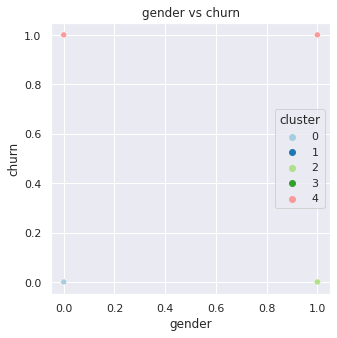

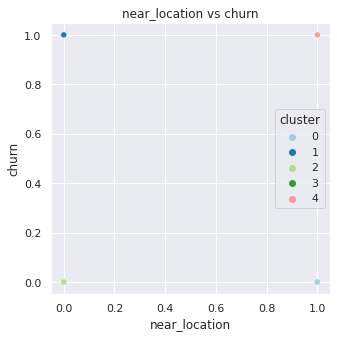

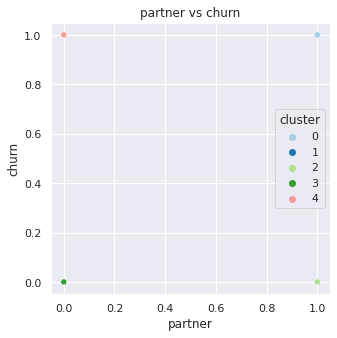

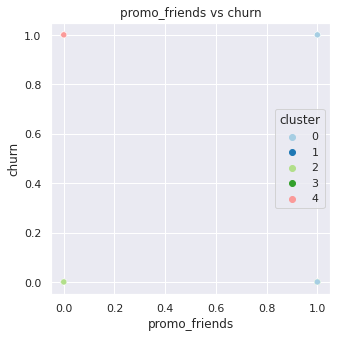

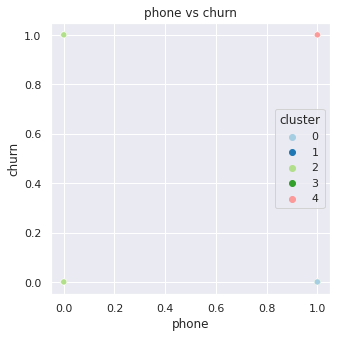

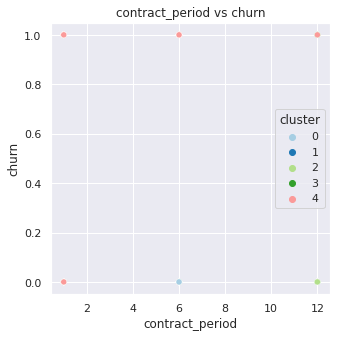

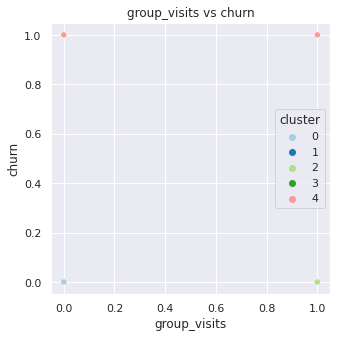

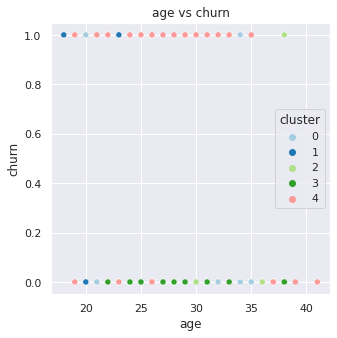

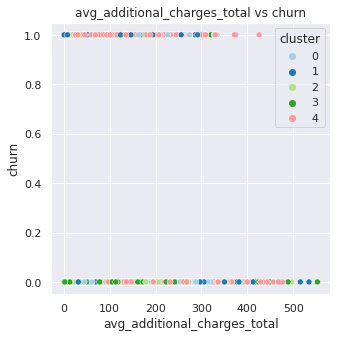

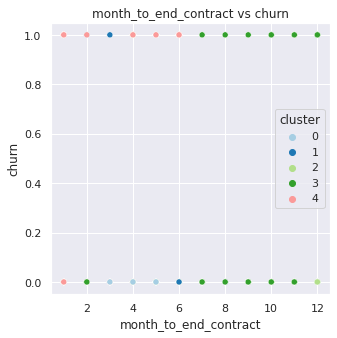

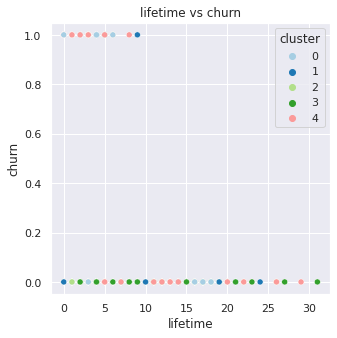

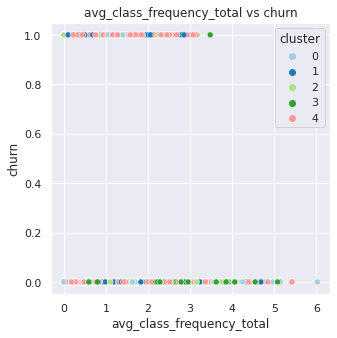

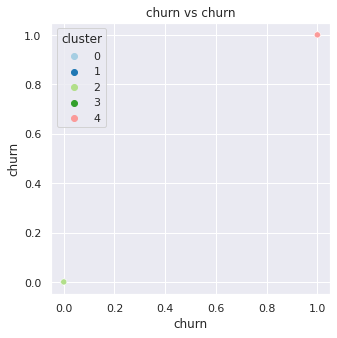

In [26]:
col_pairs = df.drop('cluster', axis=1)
for pair in col_pairs:
    show_clusters_on_plot(df, pair, 'churn', 'cluster')

In [27]:
# создание списков столбцов с различными типами признаков
bool_columns = []
numeric_columns = []
for col in df.columns: 
    if df[col].nunique() > 2:
        numeric_columns.append(col)
    else:
        bool_columns.append(col)

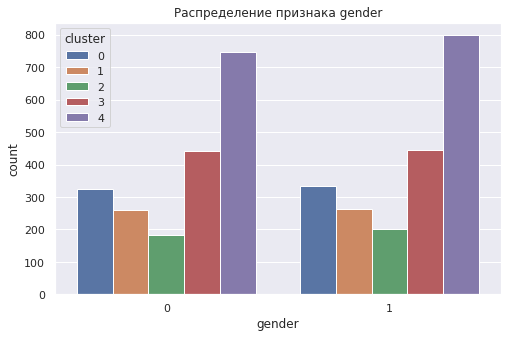

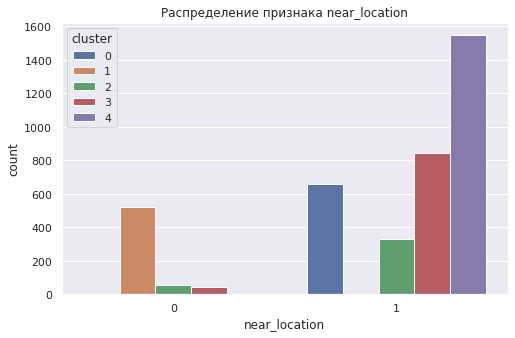

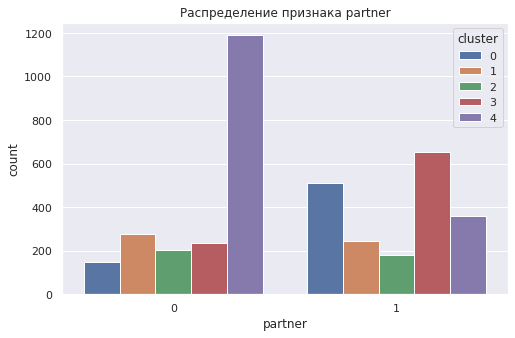

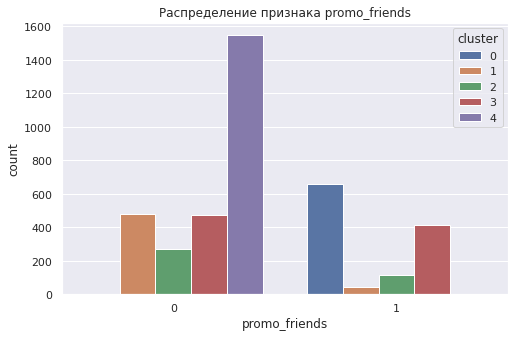

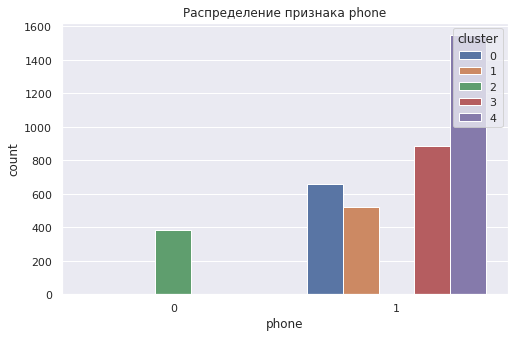

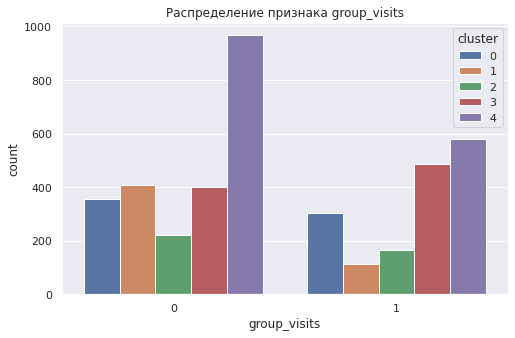

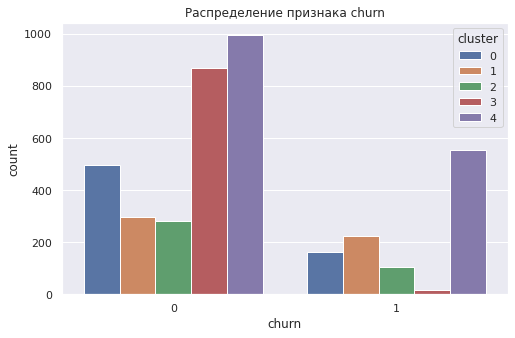

In [28]:
# Код ревьюера 
# Например, для булевых значений, которые ты вынесла в лист)

    
for column in bool_columns:
    plt.figure(figsize=(8,5))
    sns.countplot(x = df[column], hue='cluster', data=df)
    plt.title('Распределение признака ' + column)
    plt.show()

**Кластеры 1 и 0:**

- клиенты с самой большой вероятностью оттока,
- самая низкая продолжительность контракта;
- самое низкое среднее количество посещений групповых занятий (но для кластера 1 оно почти такое же, как в 2 и 4);
- самая значительная разница между посещением в среднем и посещением за последний месяц - второе значительно ниже,
- для кластера 0 характерен самый низкий среди всех кластеров средний возраст;
- при этом пользование партнерскими программами и приглашениями друзей для кластера 0 все же выше, чем для 1, хотя оба эти значения самые низкие в датасете;
- в кластер 0 попали только те, кто не живет/работает возле фитнес-центра.

**Кластер 2:**

- клиенты с самой большой длительностью контракта,
- с высокой вероятностью пользующиеся партнерской программой или приглашениями друзей,
- самые большие траты на дополнительные услуги фитнес-центра,
- самая большая вероятность посещения групповых занятий,
- самая высокая посещаемость, которая не падает за последний месяц,
- живут или работают возле фитнес-центра.

**Кластеры 3 и 4:**

- меньший срок контракта и меньшее количество посещений групповых занятий, чем в кластере 3;
- приблизительно тот же средний возраст, что в кластере 3,
- для них характерна меньшая частота посещений (менее 2), которая падает за последний месяц;
- при этом уровень пользования партнерскими программами и приглашениями друзей в кластере 2 самый высокий для всего датасета, вероятно, поэтому отток в нем чуть ниже, чем в кластере 4 - в частности, весь кластер 2 пользовался приглашениями друзей;
- длительность контракта в кластере 4 выше, чем в 2.


Графики подтверждают сделанные ранее выводы, показывая соотношения без учета численности клиентов в кластерах:

в частности, отчетливо выделяется максимальный отток для кластера 0, меньший для 1, 2 и 4, и минимальный для 3;
никто из кластера 0 не живет/работает около фитнес-клуба;
самый большой процент пользования партнерскими соглашениями - у кластеров 2 и 3,
весь кластер 2 и половина кластера 3 попала в фитнес-клуб по приглашению друзей, и напротив, никто из кластера 1 и почти весь кластер 0 таким приглашением не пользуется,
кластер 0 с наименьшей вероятностью посещает групповые занятия, а кластер 2 - с наибольшей.

In [29]:
mean_churn = df.groupby('cluster')['churn'].agg('mean').to_frame(name='mean_churn')
mean_churn['cluster'] = mean_churn.index 
mean_churn

,mean_churn,cluster
cluster,,
0,0.247344,0
1,0.429119,1
2,0.266839,2
3,0.020293,3
4,0.357697,4


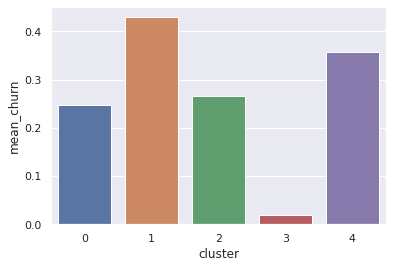

In [30]:
sns.barplot(x='cluster', y='mean_churn', data=mean_churn);

## Шаг. Общий вывод.

**Выводы по проделанной работе**

В результате предварительного анализа данных пропусков и дубликатов не обнаружили. Наиболее информативными для дальнейшего анализа выглядат длительность текущих абонементов (в среднем ниже у ушедших), посещение групповых занятий (оставшиеся более склонны к посещению групповых занятий), является ли человек сотрудником компании-партнёра клуба (для таких посетителей действует скидка, что может положительно влиять на решение человека продолжить посещение клуба). Тогда как на первый взгляд возраст, пол, наличие контактного телефона не отличаются у ушедших и оставшихся клиентов, а значит, возможно не так важны для дальнейшего анализа.

Построили модель прогнозирования оттока клиентов. Модель логистической регрессии показала себя немного лучше, чем модель градиентного леса по всем метрикам. Выбираем модель логической регрессии.

В результате кластеризации выделили 5 кластеров клиентов: кластеры 0 и 1 обладали наименьшим оттоком и различались по параметру живет-не живет рядом с фитнес-центром, в остальном это были клиенты которые пользовались программами лояльности, приобретали годовые и полугодовые абонементы, и посещали около 2 раз в неделю зал; кластеры 3 и 4 имели наибольшую вероятность оттока - это клиенты с короткими абонементами или маленьким сроком до конца абонемента, которые посещали зал менее 2 раз в неделю и не пользовались программами лояльности.

**Рекомендации для бизнеса**

Факторы, влияющие на отток пользователей:

- младший возраст,
- удаленное расстояние до проживания/работы,
- абонементы на короткий срок

Клиенты перед в группе риска по оттоку снижают количество посещений, возможно таких клиентов стоит выделять и предлагать им персональные условия что бы они не уходили.

Постоянные клиенты которые имеют долгосрочные абонементы активнее пользуются дополнительными услугами фитнес-центра и чаще его посещают, значит нужно стараться выстроить маркетинговую стратегию так что бы больше клиентов становились долгосрочными и постоянными, например система скидок на годовые абонементы, так же эти клиенты активно пользовались программами лояльности. Программы лояльности работают и приносят "качетсвенных" долгосрочных клиентов.

Нужно обратить отдельное внимание на клиентов младше и старше (в фитнес-клубе почти нет клиентов старше 40), чем средняя аудитория, и сделать какие-то специальные акции и предложения для них.